# ABCM Computer lab 3: Population effects & Cultural evolution

This notebook contains a reproduction of the model by Cuskley et al. (2018) in python.
Below follows a brief walk-through of the code.

To load the code into your notebook, make sure to run each of the code cells below in turn.

First, let's import the necessary packages:

In [1]:
import random
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns

We start by setting a bunch of parameters.
Unfortunately, the code takes a while to run. To make it feasible to run some simulations in a reasonable amount of time, the code below therefore makes a number of changes compared to the Cuskley et al. (2018) parameter settings. See the parameter settings below; the comment after each parameter states what setting Cuskley et al. (2018) used.

These measures should hopefully allow you to run the relevant simulations in around 15 min per condition. 

Have a look at each of the parameters below, and check whether you understand which parameter or condition described in Cuskley et al. (2018) they correspond to.

In [2]:
n_runs = 2  # int: number of independent simulation runs. Cuskley et al. (2018) used 100
pop_sizes = [20, 100]  # list of ints: initial pop sizes. Cuskley et al. (2018) used 20 for small and 100 for large pop
n_lemmas = 14  # int: number of lemmas. Cuskley et al. (2018) used 28
n_tokens = 250  # int: number of tokens in vocabulary. Cuskley et al. seem to have used 500 (in C++ implementation)
n_inflections = 6  # int: number of inflections. Cuskley et al. (2018) used 12
zipf_exponent = 2  # int: exponent used to create Zipfian frequency distribution. Cuskley et al., 2018 used 2
k_proficiency = 250  # int: token threshold that determines proficiency. Cuskley et al. (2018) used 1500
r_replacement = 0.001  # float: replacement rate for turnover condition. Cuskley et al. (2018) used 0.001.
# At every interaction, there is an r chance that a randomly selected learner will be replaced by a new learner
g_growth = 0.001  # float: growth rate for growth condition. Cuskley et al. (2018) used 0.001.
# At every interaction, there's a g chance that a new learner will be *added* to the population
replacement = True  # Boolean: determines whether this simulation includes replacement (turnover)
growth = False  # Boolean; determines whether this simulation includes growth
t_timesteps = 5000  # int: number of timesteps to run per simulation. Cuskley et al. (2018) used 10,000
d_memory = 100  # int: no. of timesteps after which agent forgets lemma-inflection pairing. Cuskley et al. used 100


We start with a function that can create a vocabulary array that contains n_tokens tokens of n_lemmas types, with a Zipfian frequency distribution.

Skim the function and check whether you understand what it's doing and why.

In [3]:
def generate_vocab(n_lemmas, zipf_exponent, n_tokens):
	"""
	Generates a vocabulary (numpy array of n_tokens tokens of n_lemmas types, with Zipfian frequency distribution)
	:param n_lemmas: int: number of lemmas
	:param zipf_exponent: int: exponent used to create Zipfian frequency distribution. Cuskley et al., 2018 used 2
	:param n_tokens: int: number of tokens in vocabulary. Cuskley et al. seem to have used 500 (in C++ implementation)
	:return: (1) numpy array containing n_tokens tokens of n_lemmas types; (2) numpy array with log frequency per lemma
	"""
	lemma_indices = np.arange(n_lemmas)  # create numpy array with index for each lemma
	zipf_dist = np.random.zipf(zipf_exponent, size=n_lemmas)  # create Zipfian frequency distribution for lemmas
	zipf_dist_in_probs = np.divide(zipf_dist, np.sum(zipf_dist))
	zipf_dist_for_n_tokens = np.multiply(zipf_dist_in_probs, n_tokens)
	zipf_dist_for_n_tokens = np.ceil(zipf_dist_for_n_tokens)  # Round UP, so that we get *at least* n_tokens in vocab
	vocabulary = np.array([])
	for i in range(len(lemma_indices)):
		lemma_index = lemma_indices[i]
		lemma_freq = zipf_dist_for_n_tokens[i]
		vocabulary = np.concatenate((vocabulary, np.array([lemma_index for x in range(int(lemma_freq))])))
	for j in range(2):  # doing this twice because sth weird w/ np.delete() function: doesn't always delete all indices
		# (possibly to do with later index going out of bounds once previous indices have been deleted)
		if vocabulary.shape[0] > n_tokens:  # if vocab is larger than n_tokens, randomly remove excess tokens
			random_indices = np.random.choice(np.arange(vocabulary.shape[0]), size=(vocabulary.shape[0] - n_tokens))
			vocabulary = np.delete(vocabulary, random_indices)
	np.random.shuffle(vocabulary)  # finally, shuffle the array so that tokens of lemmas occur in random order
	vocabulary = vocabulary.astype(int)
	return vocabulary, np.log(zipf_dist_in_probs)


The rest of the code is divided up into the following four classes: (In object-oriented programming languages like Python, a class is essentially a collection of attributes and functions that belong together.)

- ```Inflection```
- ```Lemma```
- ```Agent```
- ```Simulation```

## Inflection and Lemma classes:

We start with the Inflection class. This class defines an inflection as paired with a lemma.

Skim the Inflection class and check whether you understand what it's doing and why.

In [4]:
class Inflection:
	"""
	Class which defines an inflection as paired with a lemma
	"""
	def __init__(self, interactions=0, successes=0, weight=np.nan, last_interaction=np.nan):
		"""
		Initialises Inflection object
		:param interactions: int: number of interactions agents has had about this lemma
		:param successes: int: no. of successful interactions agent has had about this lemma
		:param weight: float: no. of successes / no. of interactions. Initialised as NAN for pairing is non-existent
		:param last_interaction: int: timestep when the pairing was last encountered, later compared against d_memory
		"""
		self.interactions = interactions
		self.successes = successes
		self.weight = weight
		self.last_interaction = last_interaction

	def empty_inflection(self):
		"""
		Empties the inflection by resetting each of its attributes; used by Lemma.purge() method when memory window
		(i.e., d_memory timesteps) has elapsed since last interaction with this inflection
		:return: resets each of the inflection object's attributes; doesn't return anything
		"""
		self.interactions = 0
		self.successes = 0
		self.weight = np.nan
		self.last_interaction = np.nan
        

Next is the Lemma class, which can update the inflections of a given lemma depending on the outcomes of interactions between agents:

In [5]:
class Lemma:
	"""
	Lemma class
	"""
	def __init__(self, lemma_index, tokens, seen, inflections):
		"""
		Initialises Lemma object
		:param lemma_index: int: index of the lemma
		:param tokens: int: number of times the agent has encountered this lemma
		:param seen: Boolean: whether the agent has encountered this lemma before
		:param inflections: dictionary with keys: "interactions", "successes", "weight", "last_interaction"
		"""
		self.index = lemma_index
		self.tokens = tokens
		self.seen = seen
		self.inflections = inflections

	def reset_lemma(self):
		"""
		Initialises/resets all attributes of the lemma object
		:param self:
		:return:
		"""
		self.tokens = 0
		self.seen = False
		self.inflections = [Inflection() for i in range(n_inflections)]  # n_inflections is global variable

	def add_inflection(self, infl_index, outcome, timestep):
		"""
		Adds an inflection to the lemma (as a result of an interaction in which that inflection was used),
		with weight depending on the outcome of the interaction (success or failure) and the number of
		previous interaction in which this inflection was used
		:param infl_index: int: index of the inflection in self.inflections
		:param outcome: int: 1 if success (i.e., if receiver has lemma-inflection pairing in inventory), 0 if failure
		:param timestep: int: timestep of current interaction
		:return: updates attributes of lemma object; doesn't return anything
		"""
		self.seen = True
		self.tokens = 1
		self.inflections[infl_index].interactions = 1
		self.inflections[infl_index].successes = outcome
		self.inflections[infl_index].weight = float(outcome) / float(self.inflections[infl_index].interactions)
		self.inflections[infl_index].last_interaction = timestep

	def update_inflection(self, infl_index, outcome, timestep):
		"""
		Updates a lemma-inflection pairing based on the outcome of an interaction
		:param infl_index: int: index of the inflection in self.inflections
		:param outcome: int: 1 if success (i.e., if receiver has lemma-inflection pairing in inventory), 0 if failure
		:param timestep: int: timestep of current interaction
		:return: updates attributes of lemma object; doesn't return anything
		"""
		self.tokens += 1
		self.inflections[infl_index].interactions += 1
		self.inflections[infl_index].successes += outcome
		self.inflections[infl_index].weight = float(self.inflections[infl_index].successes) / float(
			self.inflections[infl_index].interactions)
		self.inflections[infl_index].last_interaction = timestep

	def has_inflection(self, infl_index):
		"""
		Checks whether agent already has a specific inflection (indicated by infl_index) for this lemma
		:param infl_index: int: index of the inflection in self.inflections
		:return: Boolean: True if agent already has this specific inflection for this lemma, False if not
		"""
		if self.inflections[infl_index].interactions > 0:
			return True
		else:
			return False

	def get_best(self):
		"""
		Finds indices of inflections with highest weight for this lemma
		:return: int: index of highest-weighted inflection. If multiple with max weight, one is selected randomly
		"""
		weight_array = np.array([self.inflections[i].weight for i in range(len(self.inflections))])
		if np.isnan(weight_array).all() == True:  # if only NANs in the array, just choose an index randomly
			max_index = np.random.choice(np.arange(
				len(self.inflections)))
		else:
			max_weight = np.nanmax(weight_array)
			max_indices = np.where(weight_array == max_weight)[0]
			max_index = np.random.choice(max_indices)
		return max_index

	def has_any_inflection(self):
		"""
		Checks whether this lemma has any inflections yet (this is considered to be the case if any of the possible
		inflections have come up in an interaction about this lemma before).
		:return: Boolean: False if lemma object doesn't have any inflections yet; True if it does
		"""
		interactions_per_inflection = np.array([self.inflections[i].interactions for i in range(len(self.inflections))])
		if np.sum(interactions_per_inflection) == 0:
			return False
		elif np.sum(interactions_per_inflection) > 0:
			return True

	def purge(self, timestep):
		"""
		Resets lemma-inflection pairing if memory window (d_memory) has elapsed
		:param timestep: int: timestep of current interaction
		:return: updates self.inflections attribute of lemma object; doesn't return anything
		"""
		for i in range(len(self.inflections)):
			if (timestep - self.inflections[
				i].last_interaction) > d_memory:  # d_memory is global variable; see parameter settings
				self.inflections[i].empty_inflection()
                

**Exercise 1:**

In this exercise, we're going to have a look at what a Lemma object looks like, and how it can be used.

In order to initialise a Lemma object, we have to specify several input arguments:
- ```lemma_index```
- ```tokens```
- ```seen```
- ```inflections```

The values of these attributes don't really matter for the purposes of the current exercise, so you can just initialise your Lemma object with random values. 

Note that the ```inflections``` input argument expects a list of Inflection objects. To create these, you can do:

```[Inflection() for i in range(n_inflections)]```

This creates a list of Inflection objects with default values.

To print the attributes of an object, you can use:

```print(object_name.__dict__)```

So, for example, assuming you have created a Lemma object named ```my_lemma```, you can do:
```print(my_lemma.__dict__)```
in order to inspect it.


**a) Write code that does the following:**
- Create a Lemma object
- write a for-loop that uses the Lemma's .update_inflection() method 10 times, where at each timestep:
    - an inflection index is selected randomly from range n_inflections
    - an outcome value is selected randomly from the options [0, 1] (representing failure and success, respectively)
    - the Lemma object's .update_inflection() method is called with the input arguments generated above (timestep is not relevant for this exercise, but you can just set it to the index of your for-loop, if you feel like it)
    - inspect the Lemma object and how it changes. This requires not just printing the lemma object, but also printing each of the Inflection objects in the lemma's self.inflections attribute (again using print(object_name.__dict__))
  
  
**b) How is the weight of a given inflection calculated each time the .update_inflection() method is called?**

In [27]:
lemma_index = 1
tokens = 1
seen = False
inflections = [Inflection() for i in range(n_inflections)]

my_lemma = Lemma(lemma_index, tokens, seen, inflections)
print(my_lemma.__dict__)


for i in range(1,10):
    print("")
    infl_index = np.random.choice(range(1, n_inflections))
    outcome = np.random.choice([0,1])
    timestep = i
    my_lemma.update_inflection(infl_index, outcome, timestep)
    for inflection in my_lemma.inflections:
        print(inflection.__dict__)
    print(f"infl_index: {infl_index};   outcome: {outcome};  timestep: {timestep}")

{'index': 1, 'tokens': 1, 'seen': False, 'inflections': [<__main__.Inflection object at 0x13eb8e1c0>, <__main__.Inflection object at 0x13eb428e0>, <__main__.Inflection object at 0x13eb42b80>, <__main__.Inflection object at 0x13eb42580>, <__main__.Inflection object at 0x13eb42c10>, <__main__.Inflection object at 0x13eb427f0>]}

{'interactions': 0, 'successes': 0, 'weight': nan, 'last_interaction': nan}
{'interactions': 0, 'successes': 0, 'weight': nan, 'last_interaction': nan}
{'interactions': 0, 'successes': 0, 'weight': nan, 'last_interaction': nan}
{'interactions': 1, 'successes': 0, 'weight': 0.0, 'last_interaction': 1}
{'interactions': 0, 'successes': 0, 'weight': nan, 'last_interaction': nan}
{'interactions': 0, 'successes': 0, 'weight': nan, 'last_interaction': nan}
infl_index: 3;   outcome: 0;  timestep: 1

{'interactions': 0, 'successes': 0, 'weight': nan, 'last_interaction': nan}
{'interactions': 1, 'successes': 1, 'weight': 1.0, 'last_interaction': 2}
{'interactions': 0, 'suc

<font color='##1589FF'>The weight is calculated based on the following formula:  
weight = number of successes for the inflection / n of interactions for the inflection<font>

<font color = "orange">
1a) Great. Although note that by using
np.random.choice(range(1, n_inflections))
the lemma with index 0 will never be chosen (remember that Python starts counting from 0).
<br>
<br>
1b) Perfect.
<font>

## Agent class:

Next, we have the Agent class, which contains all the attributes/properties of an agent (e.g., their vocabulary, how many tokens they've seen in their life so far, whether that makes them a type-generaliser or a token-generaliser, etc.), and all the functions (named "methods" if we're talking about a class) that allow the agent to interact and update their attributes/properties based on the content and outcome of that interaction.

In [29]:
class Agent:
	"""
	Agent class
	"""
	def __init__(self, tokens=0, k_threshold=k_proficiency, memory_window=d_memory, type_generalise=False,
				 is_active=False):
		"""
		Initialises Agent object
		:param tokens: int: number of tokens seen by the agent in total. Initial value: 0
		:param k_threshold: int: token threshold that determines proficiency. Default: k_proficiency (=global variable)
		:param memory_window: int: no. of timesteps after which agent forgets pairing. Default: d_memory (=global var.)
		:param type_generalise: Boolean: False = agent is token-generaliser; True = type-generaliser. Initial: False
		:param is_active: Boolean: Initial value: False. Agent's status gets changed to active when it gets added to pop
		"""
		self.tokens = tokens
		self.k_threshold = k_threshold
		self.memory_window = memory_window
		self.type_generalise = type_generalise
		self.is_active = is_active
		empty_inflections = [Inflection() for i in range(n_inflections)]  # used for initiliasing empty vocab below
		self.vocabulary = [Lemma(0, 0, False, empty_inflections) for x in range(n_lemmas)]  # initialise empty vocab

	def reset_agent(self):
		"""
		Resets agent's attributes to initial/empty
		:return: resets agent's attributes; doesn't return anything
		"""
		self.is_active = True
		self.tokens = 0
		self.type_generalise = False
		for lemma in self.vocabulary:
			lemma.reset_lemma()

	def has_inflections(self, lemma_index):
		"""
		Checks whether agent has any inflections for a particular lemma (indicated by lemma_index)
		:param lemma_index: int: index of particular Lemma object in self.vocabulary
		:return: Boolean: True if agent has any inflections for this particular lemma, False if not
		"""
		return self.vocabulary[lemma_index].has_any_inflection()

	def update_lemma(self, lemma_index, infl_index, outcome, timestep):
		"""
		Update the entry for a particular lemma
		:param lemma_index: int: index of the lemma (in the agent's self.vocabulary attribute)
		:param infl_index: int: index of the inflection
		:param outcome: int: 1 if success (i.e., if receiver has lemma-inflection pairing in inventory), 0 if failure
		:param timestep: int: timestep of current interaction
		:return: updates lemma in agent's vocabulary; doesn't return anything
		"""
		self.tokens += 1
		# If lemma-inflection pairing exists, update the weighting according to the outcome of the interaction:
		if self.vocabulary[lemma_index].has_inflection(infl_index):
			self.vocabulary[lemma_index].update_inflection(infl_index, outcome, timestep)
		# If lemma-inflection pairing doesn't exist yet, create it:
		else:
			self.vocabulary[lemma_index].add_inflection(infl_index, outcome, timestep)
		# Purge the inflections of the lemma (i.e., remove inflections that haven't been used for d_memory timesteps)
		self.vocabulary[lemma_index].purge(timestep)
		# Finally, set agent's self.type_generalise attribute depending on how many tokens it has encountered in total
		if self.tokens > self.k_threshold:
			self.type_generalise = True
		else:
			self.type_generalise = False

	def get_best(self, lemma_index):
		"""
		Get best (i.e., heighest-weighted) inflection for this lemma
		:param lemma_index: int: index of the lemma (in the agent's self.vocabulary attribute)
		:return: int: index of best (i.e., heighest-weighted) inflection for this lemma
		"""
		return self.vocabulary[lemma_index].get_best()

	def get_token_best(self):
		"""
		Token-generalise: Look across vocab and extend rule that was used most frequently across all tokens of any type
		:return: int: index of inflection used across most *tokens*
		"""
		max_tokens = np.zeros(n_inflections)
		for lemma_index in range(len(self.vocabulary)):
			for i in range(n_inflections):
				max_tokens[i] += self.vocabulary[lemma_index].inflections[i].successes
		max_successes = np.amax(max_tokens)
		max_token_indices = np.where(max_tokens == max_successes)[0]
		max_index = np.random.choice(max_token_indices)
		return max_index

	def get_type_best(self):
		"""
		Type-generalise: Look across vocab and extend the rule which applies to the most types in agent's vocab
		:return: int: index of inflection used across most *types*
		"""
		max_types = np.zeros(n_inflections)
		for lemma_index in range(len(self.vocabulary)):
			best_inflection = self.vocabulary[lemma_index].get_best()
			max_types[best_inflection] += 1
		max_values = np.amax(max_types)
		max_token_indices = np.where(max_types == max_values)[0]
		max_index = np.random.choice(max_token_indices)
		return max_index

	def generate_inflection(self):
		"""
		If a lemma has no inflections, generate an inflection based on generalisation processes
		:return: int: index of newly generated (/generalised) inflection
		"""
		inflection_utterance = np.nan
		# If self.type_generalise is True (= when agent has exceeded k_threshold), find inflection used for most types
		if self.type_generalise:
			inflection_utterance = self.get_type_best()
			# If preferred generalisation process doesn't provide inflection, try other method (token-generalise)
			if np.isnan(inflection_utterance):
				inflection_utterance = self.get_token_best()
		# If self.type_generalise is False (=agent hasn't reached k_threshold yet) find inflection used for most tokens
		else:
			inflection_utterance = self.get_token_best()
			# If preferred generalisation process doesn't provide inflection, try other method (type-generalise)
			if np.isnan(inflection_utterance):
				inflection_utterance = self.get_type_best()
		# If agent has no inflections in vocabulary, they will choose a random inflection from the predefined set
		if np.isnan(inflection_utterance):
			inflection_utterance = np.random.choice(np.arange(n_inflections))
		return inflection_utterance

	def receive(self, lemma_index, infl_index, timestep):
		"""
		Take inflection in as receiver and update lemmas in vocabulary accordingly
		:param lemma_index: int: index of the lemma (in the agent's self.vocabulary attribute)
		:param infl_index: int: index of the inflection
		:param timestep: int: timestep of current interaction
		:return: Boolean: 1 if interaction is success (= lemma-inflection pairing in receiver's vocab), 0 otherwise
		"""
		# If agent has any inflections for this lemma:
		if self.has_inflections(lemma_index):
			# If the agent has this particular inflection for this lemma --- no matter the weight --- return success
			if self.vocabulary[lemma_index].has_inflection(infl_index):
				self.update_lemma(lemma_index, infl_index, 1, timestep)
				return 1
			else:
				self.update_lemma(lemma_index, infl_index, 0, timestep)
				return 0
		# If agent doesn't have any inflections for this lemma, generate inflection based on generalisation processes
		else:
			guess = self.generate_inflection()
			# If the newly generated inflection matches the inflection in question, return success:
			if guess == infl_index:
				self.update_lemma(lemma_index, infl_index, 1, timestep)
				return 1
			else:
				self.update_lemma(lemma_index, infl_index, 0, timestep)
				return 0

**Exercise 2:**

In this exercise, we're going to create two Agent objects and have them interact with each other. 

When you create an Agent object, you *can* specify a number of input arguments. However, the Agent class is defined in such a way that each of these input arguments has a default value. This means that you can simply create a "default" Agent using:

``` my_agent = Agent()```


**a) Write code to do the following:**
- Create two agent objects called ```agent_1``` and ```agent_2```
- Write a for-loop to loop through the following steps 10 times:
    - Randomly choose a lemma from range(n_lemmas), and print the chosen lemma
    - Randomly assign the role of producer to one of the agents, and the role of receiver to the other agent
    - Make the producer agent produce an utterance (i.e., an inflection for the lemma that was chosen above) using the Agent's ```.get_best()``` method, and print the utterance
    - Print the values in the receiver's vocabulary for the lemma-inflection pairing that was uttered, *before* running the .receive method
    - Make the receiver agent update their vocabulary based on the utterance received, using the Agent's ```.receive()``` method. Save the outcome of this interaction (= output of the ```.receive()``` method) in a variable and print it
    - Print the values in the receiver's vocabulary for the lemma-inflection pairing that was uttered, *after* running the .receive method, and inspect how they've changed.
    
    
**b) Do you notice any pattern in which inflections the agents use across the different lemmas? If so, try to explain this pattern.**

In [57]:
agent_1 = Agent()
agent_2 = Agent()

for i in range(1,10):
    print("")
    agent_rd = np.random.choice([1,2])
    if agent_rd == 1:
        producer = agent_1
        receiver = agent_2
    else:
        producer = agent_2
        receiver = agent_1
    print(f"[The producer is agent {agent_rd}]==================")

    lemma_index = np.random.choice(n_lemmas)
    print(f"lemma_index: {lemma_index}")

    utterance = producer.get_best(lemma_index)
    print(f"Utterance (inflection): {utterance}")
    print("Receiver's vocab before .receive()")
    receiver_vocab = receiver.vocabulary
    for inflection in receiver_vocab[lemma_index].inflections:
        print(inflection.__dict__)
    
    receiver.receive(lemma_index, utterance, i)
    print("")
    print("Receiver's vocab after .receive()")
    for inflection in receiver_vocab[lemma_index].inflections:
        print(inflection.__dict__)




[The producer is agent 1]==================
lemma_index: 12
Utterance (inflection): 2
Receiver's vocab before .receive()
{'interactions': 0, 'successes': 0, 'weight': nan, 'last_interaction': nan}
{'interactions': 0, 'successes': 0, 'weight': nan, 'last_interaction': nan}
{'interactions': 0, 'successes': 0, 'weight': nan, 'last_interaction': nan}
{'interactions': 0, 'successes': 0, 'weight': nan, 'last_interaction': nan}
{'interactions': 0, 'successes': 0, 'weight': nan, 'last_interaction': nan}
{'interactions': 0, 'successes': 0, 'weight': nan, 'last_interaction': nan}

Receiver's vocab after .receive()
{'interactions': 0, 'successes': 0, 'weight': nan, 'last_interaction': nan}
{'interactions': 0, 'successes': 0, 'weight': nan, 'last_interaction': nan}
{'interactions': 1, 'successes': 0, 'weight': 0.0, 'last_interaction': 1}
{'interactions': 0, 'successes': 0, 'weight': nan, 'last_interaction': nan}
{'interactions': 0, 'successes': 0, 'weight': nan, 'last_interaction': nan}
{'interac

<font color='##1589FF'>
 I don't know if I read the output correctly, but the producer seens to produce utterances based on the inflections with highest weight across lemmas, not for the particular lemma. I thought the get_best() function produces an inflection with highest weight for the lemma if the producer has already encountered the lemma or a random inflection when they haven't. In fact, for instance, the number of interactions in the third interaction should be 0 for all the inflections because they have never encounted the lemma "7" before, but it looks like they know that they have encountered the inflection for other lemmas but don't know with which lemma they encountered the inflection.<font>

<font color = "orange">
2a) Great. Although note that by using <br>
for i in range(1,10): <br>
instead of: <br>
for i in range(10):<br>
you looped through the steps 9 times instead of 10. (Again because Python starts counting from 0.)
<br>
<br>
2b) Thank you for pointing out that something weird was happening here (where neither agent should have any lemma-inflection pairings for lemma 7 yet when they encounter it for the first time). I looked into it, and it turned out there was a bug in the code for this computer lab (specifically: in the __init__() method of the Agent class: each lemma was accidentally being initiated with the same list of inflection objects, instead of with a separate list of inflection objects for each lemma). So you were completely correct in observing that the output was not behaving as expected here.
<font>

## Simulation class:

That brings us to the final class: Simulation. This class allows us to run a batch of simulation runs given the parameter settings specified at the top of the notebook.

In [58]:
class Simulation:
	"""
	Simulation class
	"""
	def __init__(self, pop_size):
		"""
		Initialises simulation object with self.pop_size, self.population and self.running_popsize
		:param pop_size: int: population size
		"""
		self.pop_size = pop_size
		self.population = [Agent() for x in range(3000)]  # Create initial pop, plus "dormant" agents to allow for growth
		self.running_popsize = pop_size  # int: keeps track of the changing population size in the growth condition
		self.n_interactions = pop_size  # int: no. of interactions per timestep. Cuskley et al. used same as pop size
		self.vocabulary, self.log_freqs_per_lemma = generate_vocab(n_lemmas, zipf_exponent, n_tokens)  # generate vocab
		self.all_tokens = 0  # Keeps track of total number of tokens that have come up in interactions across timesteps
		self.global_inflections = np.zeros(n_inflections)  # Keeps track of frequency of each inflection throughout the simulation
		self.global_counts = np.zeros(n_lemmas)  # Keeps track of the frequency of each lemma throughout the simulation
		self.pop_size_column = np.zeros(n_runs*t_timesteps*n_lemmas)
		self.r_column = np.zeros(n_runs*t_timesteps*n_lemmas)
		self.tstep_column = np.zeros(n_runs*t_timesteps*n_lemmas)
		self.lemma_column = np.zeros(n_runs*t_timesteps*n_lemmas)
		self.log_freq_column = np.zeros(n_runs * t_timesteps * n_lemmas)
		self.infl_column = np.zeros(n_runs*t_timesteps*n_lemmas)
		self.vocab_entropy_column = np.zeros(n_runs*t_timesteps*n_lemmas)
		self.meaning_entropy_column = np.zeros(n_runs*t_timesteps*n_lemmas)

	def interaction(self, producer, receiver, lemma, current_timestep):
		"""
		Run single interaction between producer and receiver
		:param producer: int: index of producer agent in self.population
		:param receiver: int: index of receiver agent in self.population
		:param lemma: int: index of lemma in agent.vocabulary
		:param current_timestep: int: current timestep
		:return: updates the lemma in the producer's and receiver's vocabulary based on how the interaction goes,
		and self.global_inflections, which keeps track of frequency of each inflection throughout the simulation;
		doesn't return anything
		"""
		if self.population[producer].has_inflections(lemma):
			utterance = self.population[producer].get_best(lemma)
			result = self.population[receiver].receive(lemma, utterance, current_timestep)
		else:
			utterance = self.population[producer].generate_inflection()
			result = self.population[receiver].receive(lemma, utterance, current_timestep)
		self.population[producer].update_lemma(lemma, utterance, result, current_timestep)
		self.global_inflections[utterance] += 1

	def replace_agent(self):
		"""
		Replace an agent in turnover condition. Randomly selects an agent from the population and resets its attributes
		(equivalent to removing the selected agent and adding a new agent)
		:return: updates self.population by resetting the attributes of the selected agent; doesn't return anything
		"""
		# Generate random float from uniform dist. [0.0, 1.0); if float <= r_replacement probability: reset random agent
		if np.random.random() <= r_replacement:
			chosen_one_index = np.random.choice(np.arange(self.running_popsize - 1))
			self.population[chosen_one_index].reset_agent()

	def add_agent(self):
		"""
		Add agent to population in growth condition by setting one of the "dormant" agents' .is_active attribute to True
		:return: updates self.population by adding a new agent (by setting .is_active to True); doesn't return anything
		"""
		if np.random.random() <= g_growth:
			self.running_popsize += 1
			# Take next of "dormant" agents in line and turn its .is_active attribute to True:
			self.population[self.running_popsize-1].is_active = True

	def timestep(self, current_timestep):
		"""
		Runs through 1 timestep in simulation. Each timestep consists of self.n_interactions interactions.
		Cuskley et al. (2018) used n_interactions = pop_size
		:param current_timestep: int: current timestep
		:return: Updates attributes of population and its agents based on the interactions they go through,
		and whether the replacement and growth conditions are turned on or off (see global variables)
		"""
		vocab_index = 0
		for i in range(self.n_interactions):
			# Randomly select producer and receiver agent:
			producer_index = np.random.choice(np.arange(self.running_popsize-1))
			receiver_index = np.random.choice(np.arange(self.running_popsize-1))
			# Make sure producer and receiver are not the same agent:
			while producer_index == receiver_index:
				receiver_index = np.random.choice(np.arange(self.running_popsize-1))
			# If we've reached the end of the vocabulary array, re-shuffle it:
			if vocab_index >= (n_tokens-1):
				np.random.shuffle(self.vocabulary)
				vocab_index = 0
			topic = self.vocabulary[vocab_index]
			self.interaction(producer_index, receiver_index, topic, current_timestep)
			if growth:  # growth is global variable (Boolean)
				self.add_agent()
			if replacement:  # growth is global variable (Boolean)
				self.replace_agent()
			self.global_counts[topic] += 1
			self.all_tokens += 1
			vocab_index += 1

	def inflections_in_vocab(self):
		"""
		Counts total number of inflections present in population
		:return: int: total number of inflections present in population
		"""
		infl_counts = np.zeros(n_inflections)
		total_inflections = 0.
		# First, create array which counts for each inflection how many agents in population have that inflection
		for l in range(n_lemmas):
			for a in range(self.running_popsize):
				if self.population[a].has_inflections(l):
					best_infl = self.population[a].get_best(l)
					infl_counts[best_infl] += 1
		# Then, get the total number of inflections which has a count >0 (i.e. that is used by at least 1 agent in pop)
		for i in range(n_inflections):
			if infl_counts[i] > 0:
				total_inflections += 1
		return total_inflections

	def get_entropy(self, probability_array):
		"""
		Calculates the entropy from a list of probablities/frequencies
		:param probability_array: 1D numpy array containing probabilities (i.e., should sum to 1.0)
		:return: float: entropy
		"""
		entropy = 0.
		for p in probability_array:
			if p > 0.:
				entropy += p * np.log2(1./p)
		return entropy

	def vocabulary_entropy(self):
		"""
		Calculates entropy of inflection across the vocabulary, H_v
		:return: float: H_v
		"""
		# how predictable is the inflection of any given lemma?
		# for each lemma
		inflection_probs = np.zeros(n_inflections)
		denominator = 0.
		for l in range(n_lemmas):
			for a in range(self.running_popsize):
				if self.population[a].vocabulary[l].has_any_inflection():
					denominator += 1
					best_infl = self.population[a].get_best(l)
					inflection_probs[best_infl] += 1
		inflection_probs = np.divide(inflection_probs, denominator)
		return self.get_entropy(inflection_probs)

	def meaning_entropy(self, lemma):
		"""
		Calculates entropy of the inflection for a specific lemma, H_l
		:param lemma: int: index of lemma that should be conditioned on
		:return: float: H_l
		"""
		# what is the probability of each inflection given this lemma?
		inflections = np.zeros(n_inflections)
		lemma_count = 0.
		for a in range(self.running_popsize):
			if self.population[a].has_inflections(lemma):
				best_infl = self.population[a].get_best(lemma)
				inflections[best_infl] += 1.
				lemma_count += 1.
		inflection_probs = np.divide(inflections, lemma_count)
		return self.get_entropy(inflection_probs)

	def single_run(self, run_number, counter):
		"""
		Runs a single simulation. Each run is t_timesteps long (Cuskley et al., 2018 used 10,000)
		:param run_number: int: index of current run
		:return: Updates the Simulation object's attributes (specifically the results arrays); doesn't return anything
		"""
		for t in range(t_timesteps):
			if t % 500 == 0:  # after every 50 timesteps, print the current timestep, so we know where we're at:
				print("t: "+str(t))
			self.timestep(t)
			total_inflections = self.inflections_in_vocab()
			if t == t_timesteps-1:
				vocab_entropy = self.vocabulary_entropy()
			for lemma_index in range(n_lemmas):
				self.pop_size_column[counter] = self.pop_size
				self.r_column[counter] = run_number
				self.tstep_column[counter] = t
				self.lemma_column[counter] = lemma_index
				self.log_freq_column[counter] = self.log_freqs_per_lemma[lemma_index]
				self.infl_column[counter] = total_inflections
				if t == t_timesteps-1:
					self.vocab_entropy_column[counter] = vocab_entropy
					self.meaning_entropy_column[counter] = self.meaning_entropy(lemma_index)
				else:
					self.vocab_entropy_column[counter] = np.nan
					self.meaning_entropy_column[counter] = np.nan
				counter += 1
		print("self.running_popsize at end of simulation:")
		print(self.running_popsize)
		return counter

	def multi_runs(self):
		"""
		Runs multiple runs of the simulation
		:return: pandas dataframe containing all results
		"""
		for i in range(self.pop_size):
			self.population[i].is_active = True
		counter = 0
		for r in range(n_runs):
			print('')
			print("r: "+str(r))
			# First, reset self.all_tokens, self.global_inflections, and self.global_counts before starting a new run:
			self.all_tokens = 0
			self.global_inflections = np.zeros(n_inflections)
			self.global_counts = np.zeros(n_lemmas)
			# Then, run a new run:
			counter = self.single_run(r, counter)
		# After all runs have finished, turn the numpy arrays with results into a pandas dataframe:
		results_dict = {"pop_size": self.pop_size_column,
						"run": self.r_column,
						"timestep": self.tstep_column,
						"lemma": self.lemma_column,
						"log_freq": self.log_freq_column,
						"n_inflections": self.infl_column,
						"vocab_entropy": self.vocab_entropy_column,
						"meaning_entropy": self.meaning_entropy_column}
		results_dataframe = pd.DataFrame(results_dict)
		return results_dataframe

## Final functions for running simulations and plotting results

We have now seen all the classes that the code for this model consists of. In addition to those, we also need a function that can run simulations for several population sizes, and combine their results into one big dataframe, which also gets saved as a pickle file (to your current working directory).

In [59]:
def run_multi_sizes(pop_sizes):
	"""
	Runs simulations for each pop_size in pop_sizes
	:param pop_sizes: list of ints specifying the different population sizes that should be run
	:return: pandas dataframe containing simulation results for all pop_sizes in pop_sizes
	"""
	start_time = time.time()
	frames = []
	# First run simulations for each of the pop_sizes:
	for pop_size in pop_sizes:
		print('')
		print("pop_size is:")
		print(pop_size)
		simulation = Simulation(pop_size)
		results_dataframe = simulation.multi_runs()
		frames.append(results_dataframe)
		print("Simulation(s) took %s minutes to run" % round(((time.time() - start_time) / 60.), 2))
	# Then combine the results for each of the pop_sizes into one big dataframe, so that they can be plotted together:
	combined_dataframe = pd.concat(frames, ignore_index=True)
	combined_dataframe.to_pickle("./results_"+"n_runs_"+str(n_runs)+"_tsteps_" + str(t_timesteps) +"_replacement_"+str(replacement)+"_growth_"+str(growth)+"_n_lem_"+str(n_lemmas)+"_n_infl_"+str(n_inflections)+"_n_tok_"+str(n_tokens)+".pkl")
	return combined_dataframe


Finally, we need a couple of plotting functions. The resulting plots also get saved as pdfs.

In [60]:
def plot_vocab_entropy(results_df): #Figure A
	sns.set_style("darkgrid")
	with sns.color_palette("deep", 2):
		sns.displot(data=results_df, x="vocab_entropy", hue="pop_size", kind="kde", fill=True)
	plt.savefig("./Hv_plot_"+"n_runs_"+str(n_runs)+"_tsteps_" + str(t_timesteps) +"_replacement_"+str(replacement)+"_growth_"+str(growth)+"_n_lem_"+str(n_lemmas)+"_n_infl_"+str(n_inflections)+"_n_tok_"+str(n_tokens)+".pdf")


def plot_meaning_entropy_by_freq(results_df): #Figure B
	sns.set_style("darkgrid")
	with sns.color_palette("deep", 2):
		sns.lineplot(data=results_df, x="log_freq", y="meaning_entropy", hue="pop_size")
	plt.savefig("./Hl_plot_"+"n_runs_"+str(n_runs)+"_tsteps_" + str(t_timesteps) +"_replacement_"+str(replacement)+"_growth_"+str(growth)+"_n_lem_"+str(n_lemmas)+"_n_infl_"+str(n_inflections)+"_n_tok_"+str(n_tokens)+".pdf")


def plot_active_inflections_over_time(results_df): #Figure C
	sns.set_style("darkgrid")
	with sns.color_palette("deep", 2):
		sns.lineplot(data=results_df, x="timestep", y="n_inflections", hue="pop_size")
	plt.savefig("./Inflections_plot_"+"n_runs_"+str(n_runs)+"_tsteps_" + str(t_timesteps) +"_replacement_"+str(replacement)+"_growth_"+str(growth)+"_n_lem_"+str(n_lemmas)+"_n_infl_"+str(n_inflections)+"_n_tok_"+str(n_tokens)+".pdf")

**Exercise 3:**

Have a look at each of the plotting functions above, and which measures from the results_dataframe they visualise.

Are all measures that are reported in the figures in Cuskley et al. (2018) represented here? If not, explain what is missing, and what that missing measure captures.

<font color='##1589FF'>
Figure (D), which captures the probability of a given lemma having its most common inflection measured across the population be the type-dominant “regular” inflection, is missing from above.<font>

<font color = "orange">
Perfect
<font>

### Example of how to run simulation:

Below is an example of how to run a simulation for each population size in the pop_sizes parameter, and to save and print the resulting dataframe. **Note** that the code cell below temporarily decreases the number of timesteps (as defined by the ```t_timesteps``` parameter at the top of the code), because the code cell below is just meant as a quick example.

In [61]:
t_timesteps = 100

results_dataframe = run_multi_sizes(pop_sizes)
print('')
print("results_dataframe is:")
print(results_dataframe)


pop_size is:
20

r: 0
t: 0
self.running_popsize at end of simulation:
20

r: 1
t: 0
self.running_popsize at end of simulation:
20
Simulation(s) took 0.06 minutes to run

pop_size is:
100

r: 0
t: 0
self.running_popsize at end of simulation:
100

r: 1
t: 0
self.running_popsize at end of simulation:
100
Simulation(s) took 0.33 minutes to run

results_dataframe is:
      pop_size  run  timestep  lemma  log_freq  n_inflections  vocab_entropy  \
0         20.0  0.0       0.0    0.0 -2.602690            6.0            NaN   
1         20.0  0.0       0.0    1.0 -3.295837            6.0            NaN   
2         20.0  0.0       0.0    2.0 -2.197225            6.0            NaN   
3         20.0  0.0       0.0    3.0 -3.295837            6.0            NaN   
4         20.0  0.0       0.0    4.0 -2.602690            6.0            NaN   
...        ...  ...       ...    ...       ...            ...            ...   
5595     100.0  1.0      99.0    9.0 -3.465736            4.0       0.0904

The simulation results have been saved in a Pandas dataframe. To extract only the results of the final timestep, for example, you can do the following:

In [62]:
final_timestep_results = results_dataframe[results_dataframe["timestep"]==t_timesteps-1]
print("final_timestep_results are:")
print(final_timestep_results)

final_timestep_results are:
      pop_size  run  timestep  lemma  log_freq  n_inflections  vocab_entropy  \
1386      20.0  0.0      99.0    0.0 -2.602690            2.0       0.703225   
1387      20.0  0.0      99.0    1.0 -3.295837            2.0       0.703225   
1388      20.0  0.0      99.0    2.0 -2.197225            2.0       0.703225   
1389      20.0  0.0      99.0    3.0 -3.295837            2.0       0.703225   
1390      20.0  0.0      99.0    4.0 -2.602690            2.0       0.703225   
1391      20.0  0.0      99.0    5.0 -3.295837            2.0       0.703225   
1392      20.0  0.0      99.0    6.0 -1.909543            2.0       0.703225   
1393      20.0  0.0      99.0    7.0 -2.197225            2.0       0.703225   
1394      20.0  0.0      99.0    8.0 -3.295837            2.0       0.703225   
1395      20.0  0.0      99.0    9.0 -1.909543            2.0       0.703225   
1396      20.0  0.0      99.0   10.0 -2.602690            2.0       0.703225   
1397      20

Just resetting the ```t_timesteps``` parameter to its original value, before we move on:

In [63]:
t_timesteps = 5000

### Plotting the results:

Now that we have a dataframe containing simulation results two different population sizes, we can plot the results using the three plotting functions defined above, as follows:

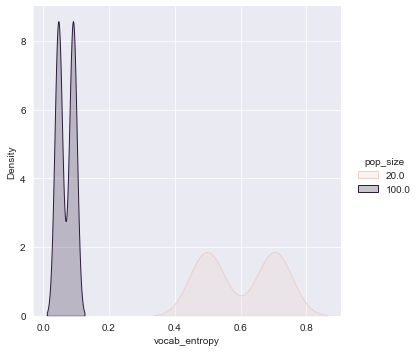

In [64]:
%matplotlib inline

plot_vocab_entropy(final_timestep_results)

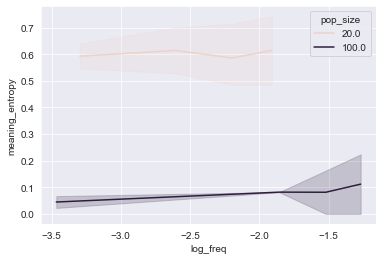

In [65]:
%matplotlib inline

plot_meaning_entropy_by_freq(final_timestep_results)

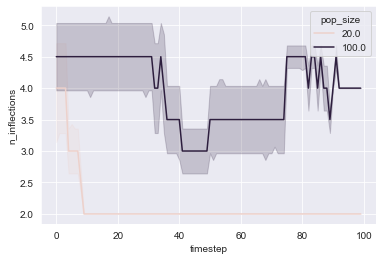

In [66]:
%matplotlib inline

plot_active_inflections_over_time(results_dataframe)

**Exercise 4:**

For this exercise, we need results of a simulation that is similar to Cuskley et al.'s "turnover" condition. Do you need to make any changes to the ```replacement``` parameter or ```growth``` parameter at the top of the notebook in order to do that? If not, feel free to re-use the ```combined_dataframe``` generated above.

Compare your own "vocab_entropy" plot with Fig. 2A of Cuskley et al. (2018).

**a)** What does the measure $H_{v}$ or "vocab_entropy" represent? 

**b)** What does the measure $H_{l}$ or "meaning_entropy" represent? And what does it mean to have an $H_{l}$ of 0.0?

**c)** Does your own "vocab_entropy" plot look similar to Cuskley et al.'s Fig. 2A? Describe both the meaningful similarities (if any) and differences (if any). If you find meaningful differences, try to explain what the cause of those might be (based on what you know about the different parameter settings used here compared to Cuskley et al., 2018).

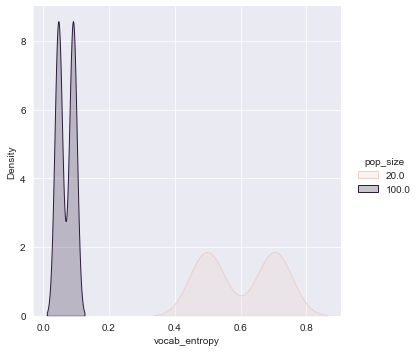

In [67]:
%matplotlib inline

plot_vocab_entropy(final_timestep_results)

<font color='##1589FF'>
a) In this model, $H_{v}$ or "vocab_entropy" represents the irregularity of inflections across lemmas: the higher the vocabulary entrophy is, the less regular the inflection system is.
<br>
<br>
b) $H_{l}$ or "meaning_entropy" represents the irregularity of inflections for a particular lemma.
<font>

<font color='##1589FF'>
c) Overall distribution of vocab_entrophy for the two population sizes is simillar for the two figures: a higher population size correlates with a more regular inflection system. However, such pattern is more prominant in the above figure compared to Cuskley et al.'s Fig. 2A. This could be because the number of inflections used for the present model is 6 while it was 12 in the paper, allowing more variety in the combination of lemmas and inflections. As the small population is more likely to allow irregular inflections, an increase in the number of inflections could have been more evident for the small population.
<font>

<font color = "orange">
4a) Correct.
<br>
<br>
4b) Correct, but this answer could do with a bit more explanation. What does it mean for "the inflections to be irregular for a particular lemma"? (Answer: this measures inter-speaker variability; so to what extent different agents in the population use different inflections for this particular lemma.) 
<br>
<br>
4c) Good answer: good analysis of one of the differences between the parameter settings used in this lab compared to those of Cuskley et al. (2018). Note, however, that the number of lemmas was also halved for this computer lab (from 28 in Cuskley et al, to 14 for this computer lab). So the ratio n_lemmas:n_inflections actually remained the same.
<font>

**Exercise 5:**

For this exercise, run a simulation that is similar to Cuskley et al.'s "growth" condition. Do you need to make any changes to the ```replacement``` parameter or ```growth``` parameter at the top of the notebook in order to do that?

**a)** Which subfigure in Cuskley et al. (2018) does your "active_inflections_over_time" plot correspond to?


**b)** For this particular model and these simulations, how would you go about deciding how many timesteps you should ideally look it? When is it ok to stop running a simulation?

**c)** Looking at your own "active_inflections_over_time" plot, and comparing it to the corresponding subfigure in Cuskley et al. (2018), do you believe that you have run your simulations for enough timesteps? If not, explain why not. Or if you find that you cannot tell based on your plot, also explain why.

In [94]:
t_timesteps = 500
replacement = False
growth = True

results_dataframe = run_multi_sizes(pop_sizes)


pop_size is:
20

r: 0
t: 0
self.running_popsize at end of simulation:
35

r: 1
t: 0
self.running_popsize at end of simulation:
46
Simulation(s) took 0.41 minutes to run

pop_size is:
100

r: 0
t: 0
self.running_popsize at end of simulation:
148

r: 1
t: 0
self.running_popsize at end of simulation:
195
Simulation(s) took 2.39 minutes to run


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


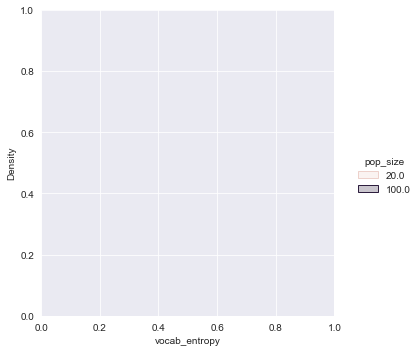

In [95]:
%matplotlib inline
final_timestep_results = results_dataframe[results_dataframe["timestep"]==t_timesteps-1]

plot_vocab_entropy(final_timestep_results)

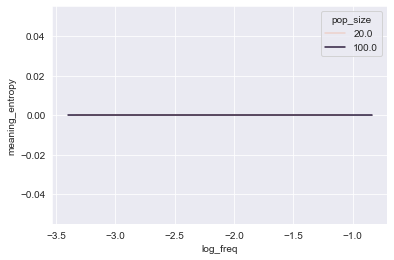

In [96]:
plot_meaning_entropy_by_freq(final_timestep_results)

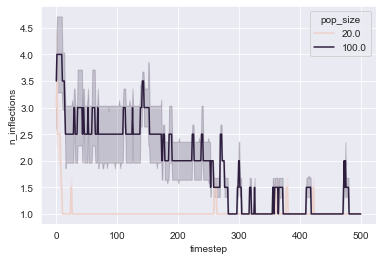

In [97]:
plot_active_inflections_over_time(results_dataframe)

<font color='##1589FF'>
a) 3C

b) I believe one can end the simulation when the active inflection is one, which is the ultimate simplification of inflection system that is led by population turnover or growth.

c) I believe I have run enough simulations, as the active inflection is close to 0. However, Figure 3(C) in the paper shows the opposite pattern: the active inflection becomes larger over time. I don't know why this is the case, as addition of new learners should lead to simpler inflection system.<font>

<font color = "orange">
5a) Correct.
<br>
<br>
5b) I understand your reasoning, but what if the conditions of the model are such that the population will always support some irregularity in the language, such that there are more than 1 active inflection? In fact, this is the case in all simulation results that Cuskley et al. (2018) report (i.e. for both lines in their figures 2C and 3C).
A better way to decide whether your simulations should keep running for more timesteps or whether you can stop them is therefore to look at whether the populations seem to have converged. One way of defining convergence for this model would be to say that a population has converged when you no longer see much change happening over time anymore in the number of active inflections in the population.
<br>
<br>
5c) In response to your observation: Cuskley et al.'s analysis of this in their paper is: "Unlike with turnover, the number of active inflections in the population over time increases (after an initial decrease) for both population sizes (Fig. 3C). An inflection is considered active if it is the highest weighted inflection for at least one lemma in at least one agent in the population. This is likely due to the constant influx of new learners, who in the early stages of acquiring rules are constantly introducing new inflections, particularly for low frequency items."
<font>

**BONUS Exercise 6 (only if you have time left):**

Read through the Simulation class more closely, and based on that, try to answer the following question:

Under which of the following conditions would you predict the run time of a simulation to increase most strongly?
1. If you double the number of lemmas in the vocabulary
2. If you double the number agents in the population
3. If you double the number of timesteps